## Relatório do TP 1 de algorítimos 2 ##

#### Autores: Lorenzo Carneiro Magalhães e Tomás Lacerda Muniz

imports 

In [16]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_iris, load_wine, load_digits, load_breast_cancer
from utils import *
from graham_scan import graham_scan
from sweep_line_intersection import sweep_line_intersection
from dataset import get_dataset
from linear_separation import linear_separation
from linear_classification import linear_classification
from svm import classify_points_svm
from pca import apply_pca

função para carregar um dataset

In [17]:
def load_dataset(input_data):
    # Check if the input is a string (filename)
    if isinstance(input_data, str):
        with open(input_data, 'r') as file:
            data = file.read()
            return data
    
    # Check if the input is a function
    elif callable(input_data):
        return input_data()

Inicializamos todos os valores de cada variável com 0, essas variáveis serão usadas para rastrear o tempo de execução do nosso algorítimo

In [18]:
time_hull = time_intersection = time_linear_sep = time_linear_class = 0

Inicializamos também os datasets em um dicionário para facilitar o acesso

In [19]:
datasets = {
        "iris": load_iris,
        "wine": load_wine,
        "digits": load_digits,
        "breast_cancer": load_breast_cancer
    }

Acompanhemos os testes na base de dados iris

In [20]:
# Carregando a base de dados em pandas
data = load_dataset(datasets["iris"])
df = pd.DataFrame(data.data, columns=data.feature_names)
df['target'] = data.target

Após carregar o banco de dados iris, vamos verificar se estes possuem mais do que 2 classes, e caso possua realizaremos um PCA para reduzir a dimensionalidade da matriz

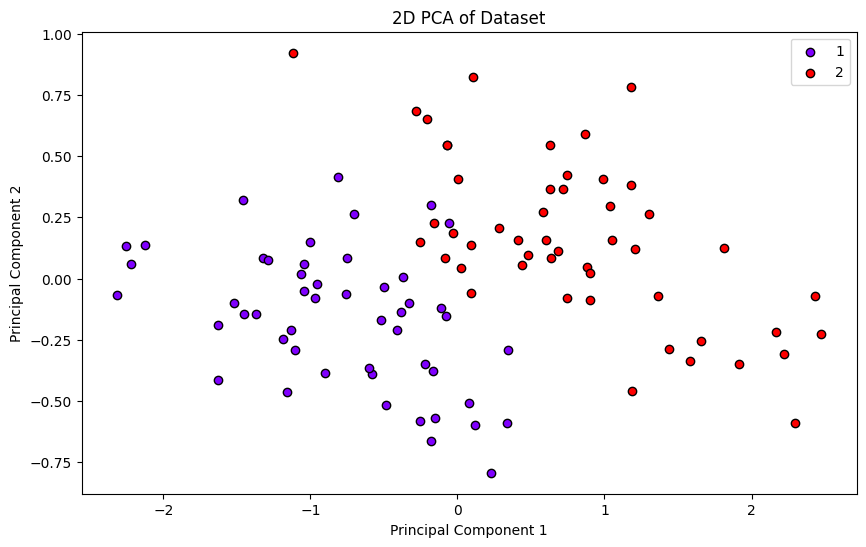

In [21]:
unique_classes = np.unique(df['target'])

if unique_classes.size > 2:
    # randomly select 2 classes
    selected_classes = np.random.choice(unique_classes, 2, replace=False)

    filtered_df = df[df['target'].isin(selected_classes)]

if df.shape[1] > 3: # 3 because of target
    # Extract data and labels from the filtered dataframe
    X_filtered = filtered_df.drop('target', axis=1).values
    y_filtered = filtered_df['target'].values

    # Apply PCA and visualize the result
    reduced_data = apply_pca(X_filtered, y_filtered, target_names=selected_classes, visualize = True)


Note que agora pegamos um dataset como o da iris e reduzimos a dimensionalidade dele para 2, isso é importante para que possamos visualizar os dados em um gráfico e por consequência traçar a envoltória

In [22]:
reduced_df = pd.DataFrame(reduced_data, columns=['x', 'y'])
reduced_df['target'] = y_filtered

reduced_df = reduced_df.sample(frac=0.2).reset_index(drop=True)

X1 = reduced_df[reduced_df['target'] == selected_classes[0]][['x', 'y']]
X2 = reduced_df[reduced_df['target'] == selected_classes[1]][['x', 'y']]

# making the hull for each
hull1, time1_ = graham_scan([Point(row['x'], row['y']) for _, row in X1.iterrows()])
hull2, time2_ = graham_scan([Point(row['x'], row['y']) for _, row in X2.iterrows()])


Segue a explicação do nosso algorítimo de graham scan para encontrar a envoltória convexa

##### EXPLICAR O GRAHAM SCAN AQUI #####

In [23]:
# Armazenando tempo
time_hull += time1_
time_hull += time2_

In [24]:
hull1_segments = hull_to_segments(hull1)
hull2_segments = hull_to_segments(hull2)

##### EXPLICAR O HULL TO SEGMENTS AQUI

In [25]:
intersection, time_ = sweep_line_intersection(hull1_segments, hull2_segments)
time_intersection += time_

if intersection:
    print("Intersects\n")
else:
    print("Not intersects")

Not intersects


##### EXPLICAR O SWEEP_LINE_INTERSECTION AQUI